Kenarlık Tespiti: Canny, Sobel, Laplacian filtreleri. Farklı kernel boyutları ile karşılaştırma.

In [1]:
!pip install datasets --quiet

from datasets import load_dataset
import os
import shutil
import random

# Oxford-IIIT Pet Dataset'ini indirme
ds = load_dataset("enterprise-explorers/oxford-pets")

# Kaydedilecek klasör
save_dir = "oxford_pet_subset"
os.makedirs(save_dir, exist_ok=True)

# 100 resim al (rastgele)
sample = ds["train"].shuffle(seed=42).select(range(100))

for i, item in enumerate(sample):
    image = item["image"]
    fname = f"{i}_{item['label']}.jpg"
    image.save(os.path.join(save_dir, fname))

print("📁 Alt küme hazır:", save_dir)


c:\Users\Kocael\.conda\envs\veri_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Kocael\.conda\envs\veri_env\lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kocael\.cache\huggingface\hub\datasets--enterprise-explorers--oxford-pets. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order 

📁 Alt küme hazır: oxford_pet_subset


In [ ]:
"""
Bu kod:

Hugging Face’den Oxford-IIIT Pet dataset’ini indirir

eğitim setinden 100 random görüntü seçer

bunları oxford_pet_subset klasörüne kaydeder

Neden bu dataset?

- Görüntü işleme algoritmaları için renkli, değişken görüntüler içerir
- SIFT / ORB gibi yön bazlı öznitelikler için iyi test olur
- Segmentasyon çalışmaları için ideal
- Farklı ışık koşulları nedeniyle threshold teknikleri sınanır
"""

Toplam görüntü: 100


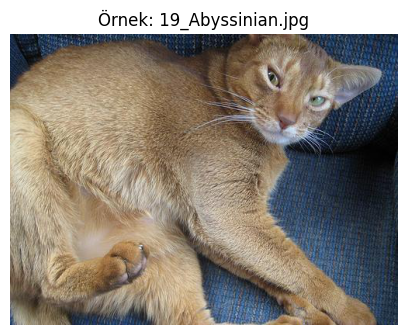

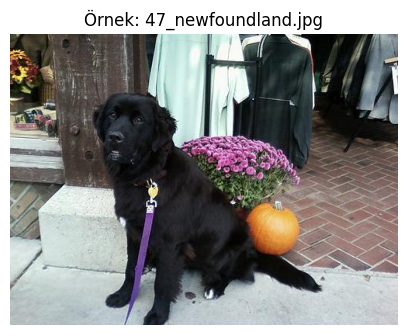

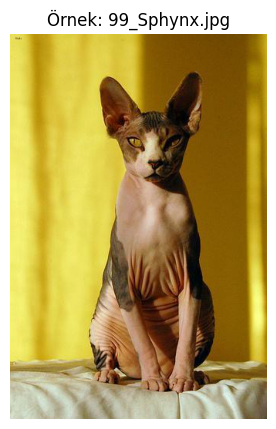

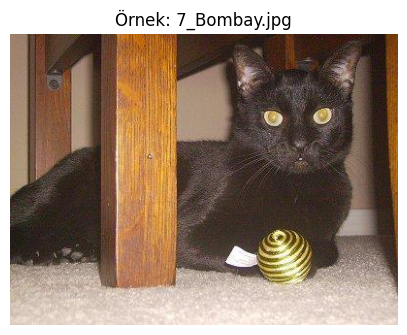

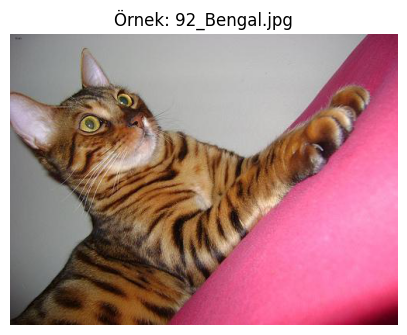

In [2]:
import os
import random
import cv2
import matplotlib.pyplot as plt

dataset_dir = "oxford_pet_subset"

img_files = [f for f in os.listdir(dataset_dir) if f.lower().endswith(".jpg")]
print("Toplam görüntü:", len(img_files))

# rastgele 5 tane seç
sample_files = random.sample(img_files, 5)

def show(img, title="Görsel", cmap=None, size=(5,5)):
    plt.figure(figsize=size)
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap if cmap else "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

for f in sample_files:
    path = os.path.join(dataset_dir, f)
    img = cv2.imread(path)
    show(img, f"Örnek: {f}")


# Bu kod dataset klasöründeki görsellerden rastgele örnekler seçip gösterir. 
# Bundan sonra her algoritma bu resimler üzerinde uygulanacak.

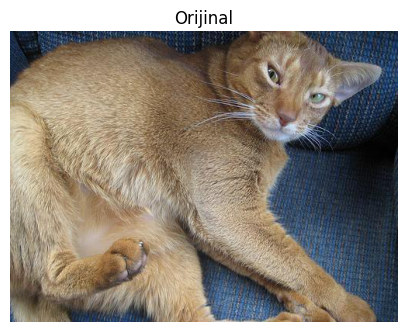

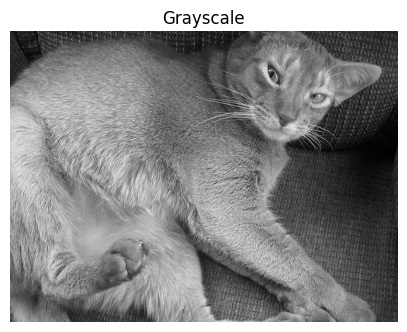

Seçilen görüntü: 19_Abyssinian.jpg


In [3]:
img_name = sample_files[0]  # istersen değiştir
img_path = os.path.join(dataset_dir, img_name)

img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

show(img, "Orijinal")
show(gray, "Grayscale")
print("Seçilen görüntü:", img_name)


1) Kenarlık Tespiti (Canny / Sobel / Laplacian + kernel karşılaştırma)


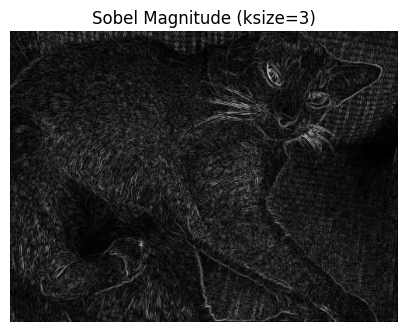

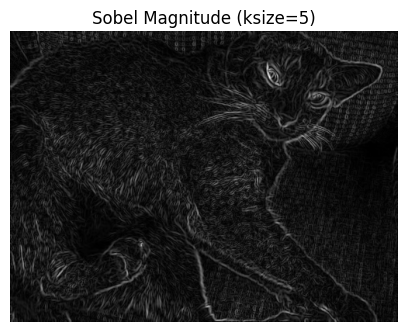

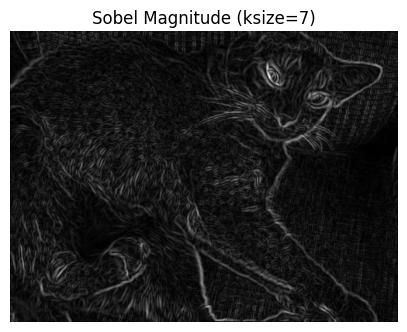

'""\nSobel filtresini farklı kernel boyutları ile uygular (3,5,7) yani 3x3 gibi\n\nX ve Y yönlü gradient hesaplar\n\nBu iki gradient’i magnitude formülüyle birleştirir\n\nSonucu normalize ederek görselleştirir\n\nKernel büyüdükçe kenarların daha yumuşak hale geldiğini karşılaştırır\n\n'

In [4]:
import numpy as np

ksizes = [3, 5, 7]

for k in ksizes:
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=k)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=k)

    mag = np.sqrt(sobelx**2 + sobely**2)
    mag = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    show(mag, f"Sobel Magnitude (ksize={k})")


"""""
Sobel filtresini farklı kernel boyutları ile uygular (3,5,7) yani 3x3 gibi

X ve Y yönlü gradient hesaplar

Bu iki gradient’i magnitude formülüyle birleştirir

Sonucu normalize ederek görselleştirir

Kernel büyüdükçe kenarların daha yumuşak hale geldiğini karşılaştırır

"""""

Laplacian Kernel Boyutu Karşılaştırma

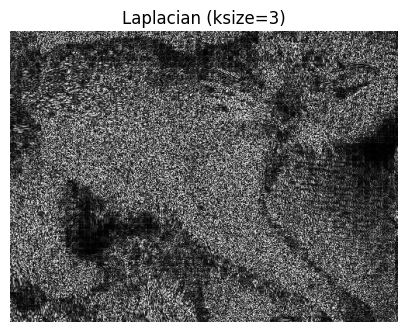

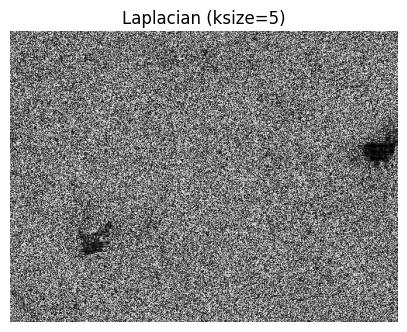

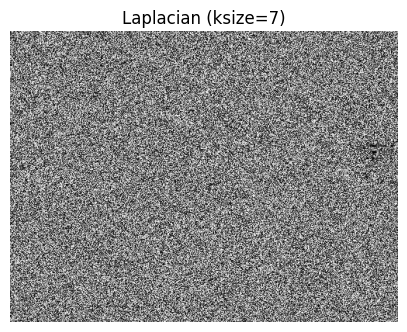

In [5]:
for k in ksizes:
    lap = cv2.Laplacian(gray, cv2.CV_64F, ksize=k)
    lap_abs = np.uint8(np.absolute(lap))
    show(lap_abs, f"Laplacian (ksize={k})")


In [6]:
#Laplacian ikinci türevdir → çok hassas. Bu yüzden bazen gürültüyü de kenar gibi algılar.
#Sonuç olarak, Laplacian ikinci türev tabanlı olduğu için görüntüdeki ani parlaklık değişimlerini güçlü biçimde vurgular. 
# Bu durum kenar tespitinde yüksek hassasiyet sağlarken, 
# gürültü de ani değişim oluşturduğu için Laplacian gürültüyü de kenar gibi algılayabilir. 
# Kernel boyutu büyüdükçe sonuç daha yumuşak ve stabil hale gelir ancak ince detayların bir kısmı kaybolabilir.

Canny (eşik karşılaştırması)

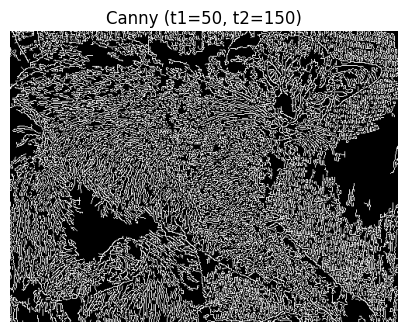

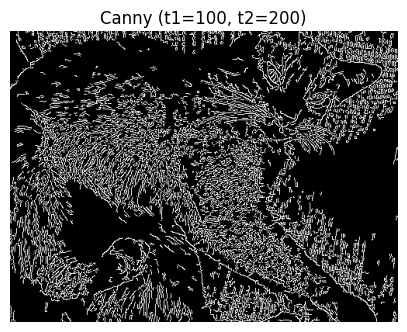

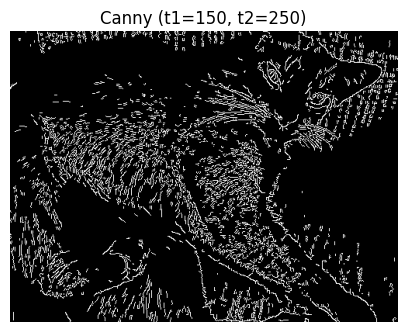

In [7]:
canny_params = [(50, 150), (100, 200), (150, 250)]

for t1, t2 in canny_params:
    edges = cv2.Canny(gray, t1, t2)
    show(edges, f"Canny (t1={t1}, t2={t2})")


In [ ]:
""" 
Canny algoritmasında kullanılan düşük ve yüksek eşikler (t1, t2), kenarların ne kadar hassas tespit edileceğini belirler. 
Düşük threshold değerleri seçildiğinde 
     zayıf parlaklık değişimleri de kenar olarak kabul edildiği için daha fazla kenar elde edilir; 
     ancak bu durum gürültünün de kenar olarak algılanmasına yol açabilir. 
Threshold değerleri yükseltildiğinde ise yalnızca güçlü geçişler kenar olarak seçilir, 
böylece daha temiz bir kenar haritası oluşur fakat ince detaylar ve zayıf kenarlar kaybolabilir.

"""

Feature Extraction (SIFT / ORB / HOG)

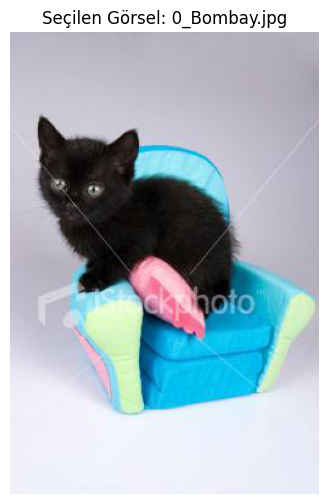

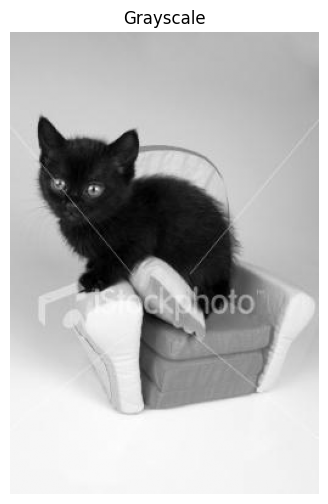

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

dataset_dir = "oxford_pet_subset"

img_files = [f for f in os.listdir(dataset_dir) if f.lower().endswith(".jpg")]
img_name = img_files[0]   
img_path = os.path.join(dataset_dir, img_name)

img = cv2.imread(img_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def show(img, title="Görsel", cmap=None, size=(6,6)):
    plt.figure(figsize=size)
    if len(img.shape) == 2:
        plt.imshow(img, cmap=cmap if cmap else "gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

show(img, f"Seçilen Görsel: {img_name}")
show(gray, "Grayscale")

#Feature extraction çoğunlukla grayscale üzerinde yapılır çünkü amaç renk değil, şekil/doku/kenar bilgisini yakalamaktır.


SIFT (Scale-Invariant Feature Transform)

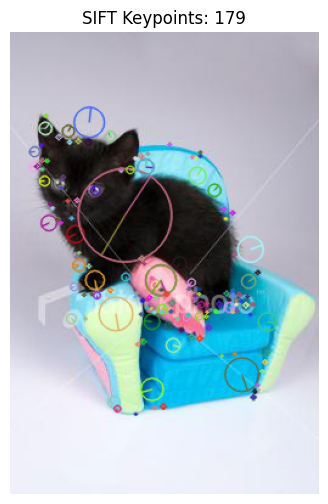

SIFT descriptor shape: (179, 128)


In [9]:
try:
    sift = cv2.SIFT_create()
    kp_sift, des_sift = sift.detectAndCompute(gray, None)

    img_sift = cv2.drawKeypoints(
        img, kp_sift, None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    show(img_sift, f"SIFT Keypoints: {len(kp_sift)}")
    print("SIFT descriptor shape:", des_sift.shape if des_sift is not None else None)

except Exception as e:
    print(" SIFT çalışmadı. Hata:", e)


In [10]:
# SIFT algoritması görüntüde ayırt edici bölgeleri keypoint olarak işaretler. 

# Görselleştirmede görülen daireler bu keypoint’leri temsil eder. 
# Dairenin merkezi keypoint’in konumunu, dairenin büyüklüğü ise keypoint’in bulunduğu ölçeği (scale) gösterir. 
# Bu sayede SIFT, görüntü ölçeği değişse bile benzer bölgeleri bulabilir. 
# Keypoint’ler genellikle köşe, kenar birleşimi ve dokulu alanlarda yoğunlaşır; düz ve tek renk bölgelerde ise azdır.
# 

ORB (Oriented FAST and Rotated BRIEF)

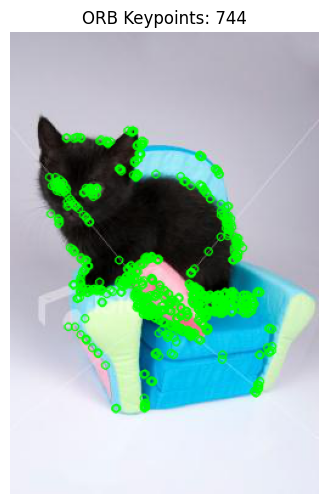

ORB descriptor shape: (744, 32)


In [11]:
orb = cv2.ORB_create(nfeatures=1000)

kp_orb, des_orb = orb.detectAndCompute(gray, None)

img_orb = cv2.drawKeypoints(
    img, kp_orb, None,
    color=(0,255,0),
    flags=0
)

show(img_orb, f"ORB Keypoints: {len(kp_orb)}")
print("ORB descriptor shape:", des_orb.shape if des_orb is not None else None)


In [ ]:
#ORB algoritması FAST ile anahtar noktaları tespit eder ve BRIEF tabanlı binary descriptor üretir. 
# Descriptor’ların 0/1 formatında olması bellek kullanımını azaltır 
# eşleştirme işlemlerini Hamming distance ile çok hızlı hale getirir.
# (Descriptor1: 10101100 Descriptor2: 10001101 Farklı bit sayısı = Hamming distance) 
# Bu nedenle ORB, gerçek zamanlı uygulamalarda sıklıkla tercih edilir. 
# Ancak SIFT’e kıyasla daha az güçlü ve daha az stabil bir yöntemdir; 
#    özellikle karmaşık ve tekrar eden desenlerde yanlış eşleşmeler veya kararsız keypoint tespiti görülebilir

HOG (Histogram of Oriented Gradients)

In [12]:
pip install scikit-image


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
    --------------------------------------- 0.3/12.8 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.8 MB 1.9 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/12.8 MB 2.3 MB/s eta 0:00:05
   ---- ----------------------------------- 1.6/12.8 MB 2.2 MB/s eta 0:00:06
   ------- -------------------------------- 2.4/12.8 MB 2.4 MB/s eta 0:00:05
   --------- ------------------------------ 2.9/12.8 MB 2.4 MB/s eta 0:00:05
   ---------- ----------------------------- 3.4/12.8 MB 2.5 MB/s eta 0:00:04
   ------------ --------------------------- 3.9/12.8 MB 2.5 MB/s eta 0:00:04
   ------------- -------------------------- 4.5/12.8 MB 2.5 MB/s eta 0:00:04
   --------------- ------------------------ 5.0/12.8 MB 2.5 MB/s eta 0:00:04
   ---------------- ----------------------- 5.2/12.8 MB 2.4 MB/s eta 0:00:04
   ------------------ ---

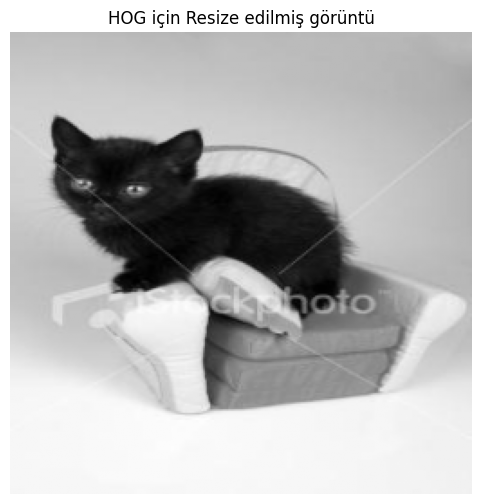

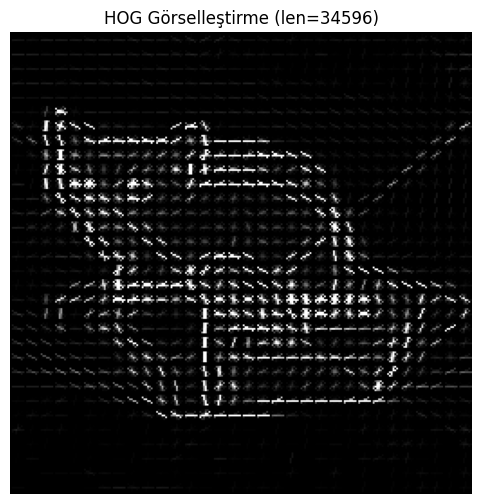

HOG feature length: 34596


In [13]:
from skimage.feature import hog
from skimage import exposure

# HOG için boyut sabitlemek daha sağlıklı
img_hog = cv2.resize(gray, (256, 256))

hog_features, hog_image = hog(
    img_hog,
    orientations=9,#0-180 derece aralığını 9 parçaya bölüyor
    pixels_per_cell=(8, 8),#görüntü 8x8 piksellik küçük hücrelere ayrılıyor.
    cells_per_block=(2, 2),
    block_norm='L2-Hys',
    visualize=True
)

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

show(img_hog, "HOG için Resize edilmiş görüntü")
show(hog_image_rescaled, f"HOG Görselleştirme (len={len(hog_features)})")
print("HOG feature length:", len(hog_features))


In [ ]:
#
# HOG yöntemi görüntüyü küçük hücrelere ayırarak her hücredeki kenar yönlerini histogram şeklinde temsil eder. 
# Bu histogramlar, kenarların yön dağılımını içerdiği için görüntünün şekil/silüet bilgisini başarılı şekilde yakalar. 
# Ayrıca histogramlar bloklar halinde normalize edildiğinden, 
#    ışık değişimleri ve kontrast farklılıklarına karşı daha dayanıklı özellikler elde edilir. 
# Bu nedenle HOG, özellikle insan tespiti (pedestrian detection) gibi şekil tabanlı görevlerde yaygın olarak kullanılır.
# 

In [ ]:
"""
| Özellik      | SIFT / ORB             | HOG                          |
| ------------ | ---------------------- | ------------------------     |
| Çalışma tipi | Nokta bazlı (keypoint) | Bölge bazlı (grid)(histogram)|
| Amaç         | Ayırt edici noktalar   | Şekil/silüet                 |
| Çıktı        | keypoint + descriptor  | tek büyük feature vector     |
| Kullanım     | eşleştirme / takip     | sınıflandırma / tespit       |

"""

Thresholding (Eşikleme)

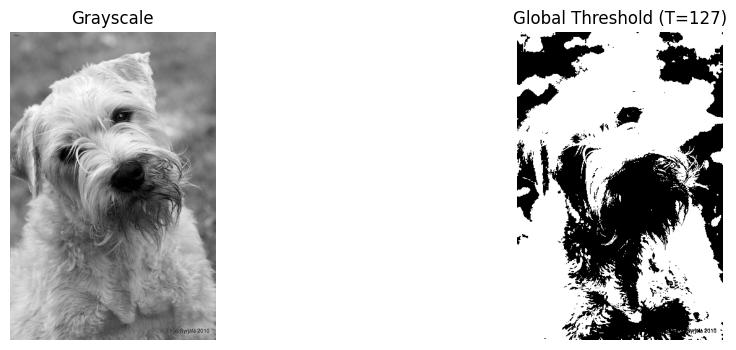

In [15]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(r"C:\Users\Kocael\Desktop\tarvina_yazilim_projects\goruntu_isleme_alg_uyg_serisi\oxford_pet_subset\16_wheaten terrier.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

T = 127
_, th_global = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.imshow(gray, cmap='gray'); plt.title("Grayscale"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(th_global, cmap='gray'); plt.title(f"Global Threshold (T={T})"); plt.axis("off")
plt.show()


In [ ]:
#Global thresholding, görüntüdeki tüm piksellere aynı eşik değeri (T=127) uygulayarak görüntüyü ikili (binary) hale getirir. 
# Bu yöntemde eşik değerinden büyük pikseller beyaz (255), küçük pikseller siyah (0) olarak atanır.
# Global thresholding hızlı ve basit bir yöntemdir; 
#     ancak görüntüde gölge, parlaklık farkı veya ışık değişimi varsa tek bir eşik değeri tüm bölgelerde iyi sonuç vermez. 
# Bu nedenle bazı bölgelerde nesne ve arka plan yanlış sınıflandırılabilir.

Otsu + Adaptive

Otsu'nun bulduğu threshold: 151.0


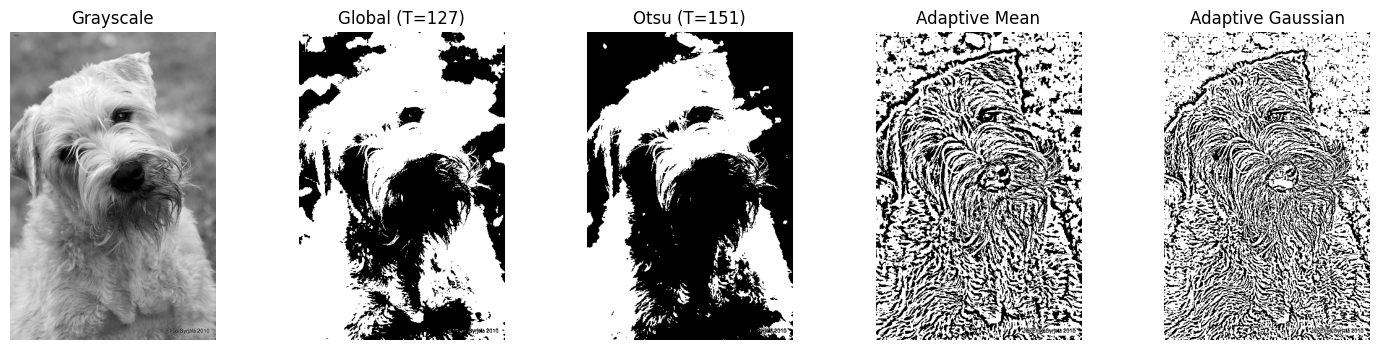

In [16]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(r"C:\Users\Kocael\Desktop\tarvina_yazilim_projects\goruntu_isleme_alg_uyg_serisi\oxford_pet_subset\16_wheaten terrier.jpg")

if img is None:
    raise FileNotFoundError("Görsel okunamadı! Dosya yolu yanlış olabilir.")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 1) Global
T = 127
_, th_global = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)

# 2) Otsu
otsu_T, th_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# 3) Adaptive Mean
th_adapt_mean = cv2.adaptiveThreshold(gray, 255,
                                      cv2.ADAPTIVE_THRESH_MEAN_C,
                                      cv2.THRESH_BINARY,
                                      11, 2)

# 4) Adaptive Gaussian
th_adapt_gauss = cv2.adaptiveThreshold(gray, 255,
                                       cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY,
                                       11, 2)

print("Otsu'nun bulduğu threshold:", otsu_T)

plt.figure(figsize=(18,4))

plt.subplot(1,5,1)
plt.imshow(gray, cmap='gray')
plt.title("Grayscale")
plt.axis("off")

plt.subplot(1,5,2)
plt.imshow(th_global, cmap='gray')
plt.title(f"Global (T={T})")
plt.axis("off")

plt.subplot(1,5,3)
plt.imshow(th_otsu, cmap='gray')
plt.title(f"Otsu (T={int(otsu_T)})")
plt.axis("off")

plt.subplot(1,5,4)
plt.imshow(th_adapt_mean, cmap='gray')
plt.title("Adaptive Mean")
plt.axis("off")

plt.subplot(1,5,5)
plt.imshow(th_adapt_gauss, cmap='gray')
plt.title("Adaptive Gaussian")
plt.axis("off")

plt.show()


In [ ]:
#YORUMLAR
"""
Otsu thresholding yöntemi, görüntünün histogramına göre eşik değerini otomatik olarak belirlemiştir. 
Bu görüntü için Otsu tarafından hesaplanan en uygun eşik değeri 151.0 olarak bulunmuştur. 
Böylece piksel değeri 
   151’in üzerinde olan bölgeler beyaz (255), 
   altında kalan bölgeler siyah (0) olarak sınıflandırılmıştır. 
Otsu yöntemi, manuel threshold seçme ihtiyacını ortadan kaldırarak 
global thresholding’e göre daha objektif ve görüntüye uyumlu sonuç üretmiştir. 
Ancak yine de tek eşik değeri kullandığı için;
   aydınlatma değişiminin fazla olduğu görüntülerde adaptive thresholding daha başarılı olabilir.


   

Global (127) vs Otsu (151) farkı ne olur?
T=127 (Global)

    daha düşük eşik

    daha fazla piksel beyaza geçer

    görüntü daha “açık” görünür

    bazen arka plan gereksiz beyazlanır

T=151 (Otsu)

    daha yüksek eşik

    daha az piksel beyaz olur

    sadece gerçekten parlak alanlar beyaz kalır

    nesne/arka plan ayrımı daha düzgün olabilir
"""

#Adaptive thresholding ise, görüntünün tamamına tek eşik uygulamak yerine, 
# görüntüyü küçük bölgelere ayırarak her bölge için ayrı bir eşik değeri hesaplar. 
# Bu sayede gölge ve ışık değişimlerinin olduğu görüntülerde daha başarılı bir ikili segmentasyon sağlar.

Morphological Operations (Morfolojik İşlemler)

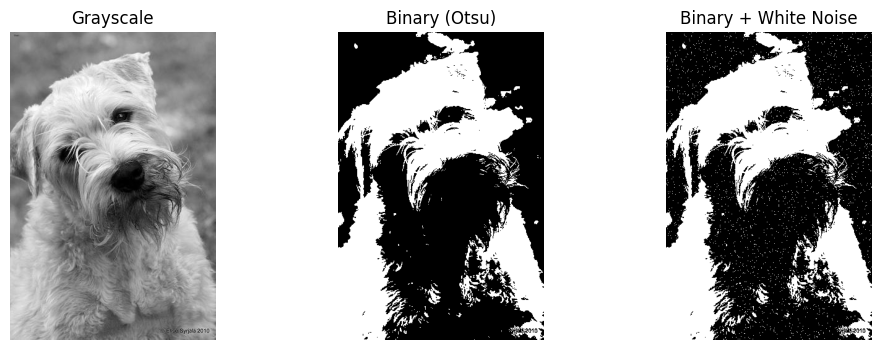

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Görsel oku
img = cv2.imread(r"C:\Users\Kocael\Desktop\tarvina_yazilim_projects\goruntu_isleme_alg_uyg_serisi\oxford_pet_subset\16_wheaten terrier.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Otsu ile binary elde edelim 
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# White noise ekleme (rastgele beyaz noktalar)
noisy = binary.copy()
h, w = noisy.shape

noise_ratio = 0.02  # %2 oranında beyaz gürültü
num_noise = int(noise_ratio * h * w)

ys = np.random.randint(0, h, num_noise)
xs = np.random.randint(0, w, num_noise)

noisy[ys, xs] = 255  # beyaz noktalar eklenir

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(gray, cmap="gray"); plt.title("Grayscale"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(binary, cmap="gray"); plt.title("Binary (Otsu)"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(noisy, cmap="gray"); plt.title("Binary + White Noise"); plt.axis("off")
plt.show()


In [ ]:
"""
Morphology nedir?

Morphological işlemler, binary görüntülerde (0-255) şekil üzerinde işlem yapar.

Yani:

255 = beyaz (nesne)

0 = siyah (arka plan)

+ Bu işlemler özellikle şunlar için kullanılır:

gürültü temizleme

delik doldurma

nesneleri büyütme/küçültme

segmentasyon sonrası düzeltme

"""

Otsu threshold: 123.0


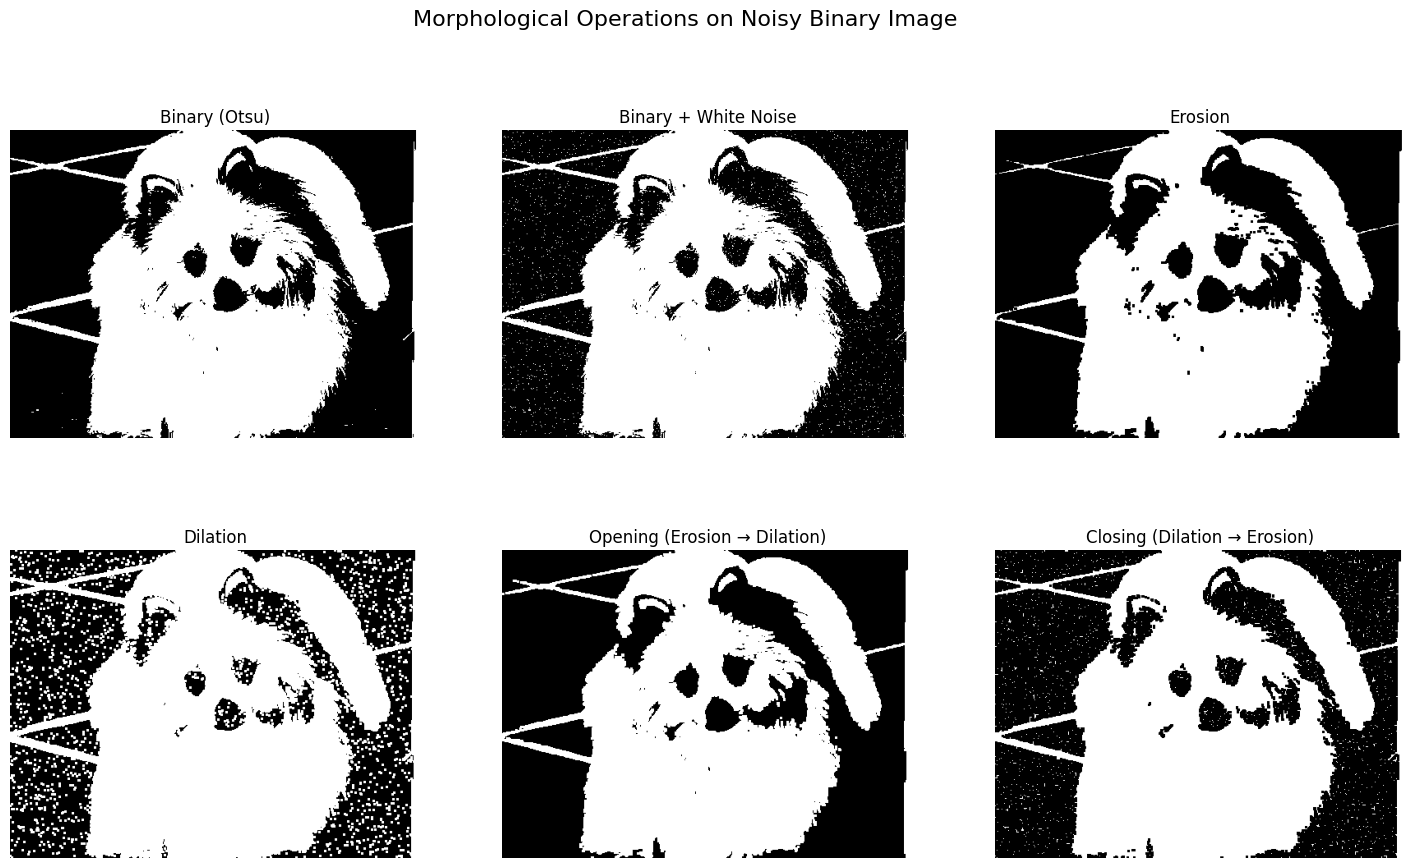

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1) Görseli oku ve grayscale'e çevir
# -------------------------------------------------------
img = cv2.imread(r"C:\Users\Kocael\Desktop\tarvina_yazilim_projects\goruntu_isleme_alg_uyg_serisi\oxford_pet_subset\15_pomeranian.jpg")

if img is None:
    raise FileNotFoundError("Görsel okunamadı! Dosya yolu yanlış olabilir.")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# -------------------------------------------------------
# 2) Binary görüntü üret (Otsu ile)
# Otsu otomatik threshold seçer ve binary üretir
# -------------------------------------------------------
otsu_T, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Otsu threshold:", otsu_T)

# -------------------------------------------------------
# 3) White Noise (beyaz gürültü) ekle
# Amaç: Morphology'nin gürültü temizleme etkisini göstermek
# -------------------------------------------------------
noisy = binary.copy()
h, w = noisy.shape

noise_ratio = 0.02  # %2 oranında beyaz gürültü (istersen 0.05 yap)
num_noise = int(noise_ratio * h * w)

ys = np.random.randint(0, h, num_noise)
xs = np.random.randint(0, w, num_noise)

# Rastgele noktalara beyaz (255) pikseller eklenir
noisy[ys, xs] = 255

# -------------------------------------------------------
# 4) Kernel (Structuring Element) tanımla
# Kernel morfolojik işlemlerin etki alanını belirler.
# 3x3: küçük etki (detay kaybı az)
# 5x5: daha güçlü etki (detay kaybı artabilir)
# -------------------------------------------------------
kernel = np.ones((3, 3), np.uint8)

# iterations: işlemin kaç kez uygulanacağını belirtir.
# iterations arttıkça erosion/dilation etkisi güçlenir.
iters = 1

# -------------------------------------------------------
# 5) Morphological Operations
# -------------------------------------------------------

# 1) Erosion (Aşındırma)
# Beyaz bölgeleri küçültür → küçük beyaz gürültüler azalır.
# Risk: Nesne de incelir/kenarlar aşınabilir.
eroded = cv2.erode(noisy, kernel, iterations=iters)

# 2) Dilation (Genişletme)
# Beyaz bölgeleri büyütür → nesne kalınlaşır.
# Risk: Gürültü de büyür.
dilated = cv2.dilate(noisy, kernel, iterations=iters)

# 3) Opening = Erosion + Dilation
# Gürültü temizlemede çok etkilidir.
opened = cv2.morphologyEx(noisy, cv2.MORPH_OPEN, kernel)

# 4) Closing = Dilation + Erosion
# Nesne içindeki küçük siyah delikleri/boşlukları kapatır.
closed = cv2.morphologyEx(noisy, cv2.MORPH_CLOSE, kernel)

# -------------------------------------------------------
# 6) Görselleştirme (2x3)
# -------------------------------------------------------
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.imshow(binary, cmap="gray")
plt.title("Binary (Otsu)")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(noisy, cmap="gray")
plt.title("Binary + White Noise")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(eroded, cmap="gray")
plt.title("Erosion")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(dilated, cmap="gray")
plt.title("Dilation")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(opened, cmap="gray")
plt.title("Opening (Erosion → Dilation)")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(closed, cmap="gray")
plt.title("Closing (Dilation → Erosion)")
plt.axis("off")

plt.suptitle("Morphological Operations on Noisy Binary Image", fontsize=16)
plt.show()


In [ ]:
#Erosion, beyaz bölgeleri aşındırarak küçük beyaz gürültüleri azaltır ancak nesnenin kenarlarını da inceltebilir.
# Dilation, beyaz bölgeleri genişleterek nesneyi büyütür ve küçük boşlukları kapatır fakat gürültüyü de büyütebilir.
# Opening (erosion→dilation) işlemi, özellikle beyaz gürültü temizlemede etkilidir çünkü küçük beyaz noktalar erosion ile silinir ve ardından nesne dilation ile geri kazanılır.
# Closing (dilation→erosion) işlemi ise nesne içerisindeki küçük siyah delikleri kapatır ve nesnenin daha bütünleşik görünmesini sağlar.

Segmentasyon: K-Means ile Renk Bazlı Clustering

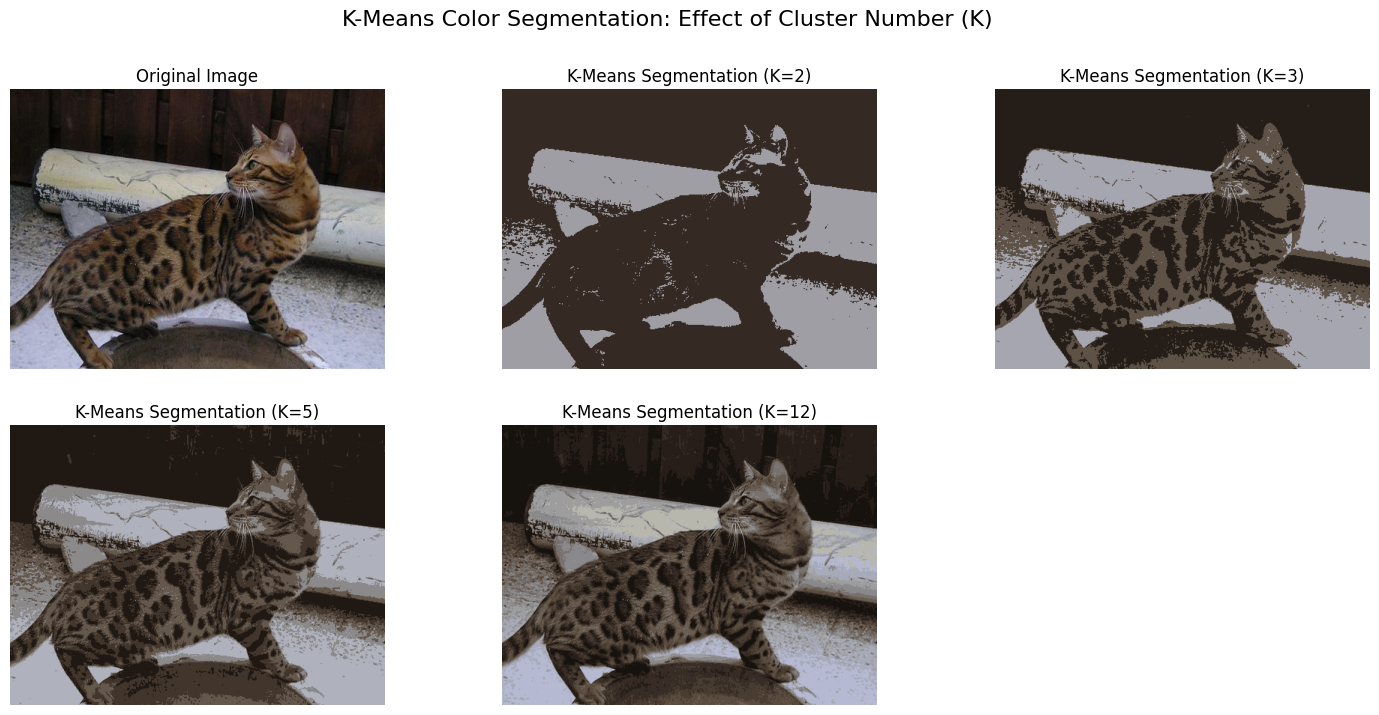

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1) Görseli oku
img = cv2.imread(r"C:\Users\Kocael\Desktop\tarvina_yazilim_projects\goruntu_isleme_alg_uyg_serisi\oxford_pet_subset\81_Bengal.jpg")

if img is None:
    raise FileNotFoundError("Görsel okunamadı! Dosya yolu yanlış olabilir.")

# OpenCV BGR okur -> RGB'ye çevir (matplotlib doğru göstersin)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# 2) Görseli piksellere indirgeme (H*W, 3)
pixel_values = img_rgb.reshape((-1, 3))
pixel_values = np.float32(pixel_values)

# 3) K-Means parametreleri
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
attempts = 10

# Denenecek K değerleri
K_values = [2, 3, 5, 12]

# Görselleştirme
plt.figure(figsize=(18, 8))

# Orijinal görüntü
plt.subplot(2, 3, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

# 4) K-Means segmentasyon sonuçları
for i, K in enumerate(K_values):
    # K-Means uygula
    compactness, labels, centers = cv2.kmeans(
        pixel_values, K, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS
    )

    # center'ları uint8 yap (0-255)
    centers = np.uint8(centers)

    # Her pikselin yeni rengini belirle
    segmented_data = centers[labels.flatten()]

    # Tekrar görüntü boyutuna getir
    segmented_img = segmented_data.reshape(img_rgb.shape)

    # Plot
    plt.subplot(2, 3, i + 2)
    plt.imshow(segmented_img)
    plt.title(f"K-Means Segmentation (K={K})")
    plt.axis("off")

plt.suptitle("K-Means Color Segmentation: Effect of Cluster Number (K)", fontsize=16)
plt.show()


In [ ]:
"""
K-Means segmentasyonu, pikselleri renk benzerliklerine göre K kümeye ayırarak görüntüyü K adet baskın renk ile temsil eder. 

K değeri düşük seçildiğinde (ör. K=2 veya K=3), görüntü daha kaba biçimde segmentlere ayrılır ve ince detaylar kaybolur. 
K değeri artırıldığında (ör. K=5 veya K=12), 
   segmentasyon daha fazla renk ve detay içerir, 
   nesne sınırları daha iyi korunur; ancak hesaplama maliyeti artar ve segment sayısı arttığı için yorumlama daha karmaşık hale gelir.

Bu çalışmada görüntü segmentasyonu amacıyla K-Means kümeleme algoritması kullanılmıştır. 
K-Means, görüntüyü oluşturan her bir pikseli (R,G,B) renk değerlerine göre ele alır 
benzer renklere sahip pikselleri aynı kümeye (cluster) yerleştirir. 

######################################

Böylece görüntü, seçilen K adet baskın renkten oluşan daha sade bir temsile dönüştürülmüş olur. 
Bu işlem segmentasyon açısından değerlendirildiğinde;
     görüntü içindeki farklı bölgelerin (arka plan, nesne, gölgeler vb.) renk benzerliklerine göre ayrıştırılmasını sağlar.

K-Means algoritmasının temel amacı,  
piksellerin kümelere olan uzaklıklarını minimize ederek (genellikle Öklid mesafesi) her küme için bir merkez belirlemektir.

######################################

Sonuç olarak her piksel, en yakın merkez renge atanır ve
   görüntü yeniden oluşturulurken her piksel kendi kümesinin merkez rengi ile temsil edilir. 
Bu nedenle segmentasyon sonucu, orijinal görüntünün “renk bazlı sadeleştirilmiş” bir versiyonu gibi görünür.   




"""

PCA: RGB görüntüyü 2 bileşene indirerek sıkıştırma

In [ ]:
""""
Bir RGB görüntüde her piksel 3 sayı ile temsil edilir:

 [R, G, B]

PCA şunu yapar:

Bu 3 boyutlu renk uzayını, en çok bilgiyi taşıyan 2 boyuta indir.

Yani PCA şunu arar:

R, G, B arasında aslında benzerlik/ilişki var mı?

Eğer varsa, 3 sayı yerine 2 sayı ile çoğu bilgiyi taşıyabilir miyiz?

+  Sonuç:

Görüntü sıkıştırılmış olur (3 → 2)

Restore edilince renkler biraz bozulabilir (kayıplı sıkıştırma gibi)
--------------------------------------------------------------------

2) PCA ile sıkıştırma mantığı

Her piksel: (R,G,B)

PCA ile 2 bileşen çıkarılır: (PC1, PC2)

Restore: tekrar (R,G,B) tahmini yapılır

Orijinal ve restore görsel kıyaslanır

"""

In [ ]:
pip install scikit-learn


📌 Image shape: (357, 500, 3)
 MSE (Orijinal vs Restore): 3.8843


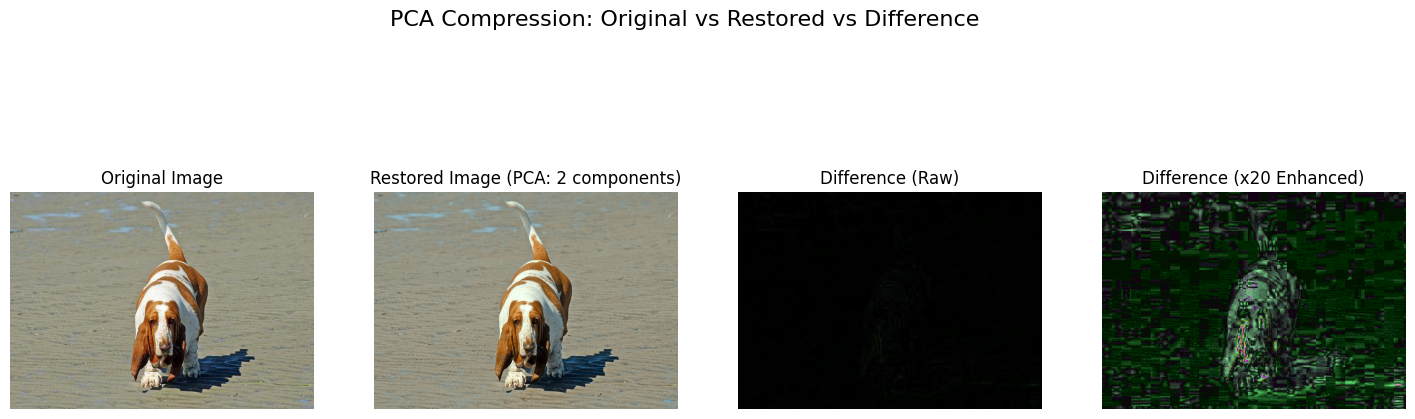

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


img_path = r"C:\Users\Kocael\Desktop\tarvina_yazilim_projects\goruntu_isleme_alg_uyg_serisi\oxford_pet_subset\79_basset hound.jpg"

# =========================================================
# 1) Görseli oku ve RGB'ye çevir
# =========================================================
img = cv2.imread(img_path)

if img is None:
    raise FileNotFoundError("❌ Görsel okunamadı! Dosya yolu yanlış olabilir.")

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Görsel boyutu
h, w, c = img_rgb.shape
print(f"📌 Image shape: {img_rgb.shape}")

# =========================================================
# 2) PCA için veriyi hazırla
# PCA piksel bazlı çalışacak: (H*W, 3)
# =========================================================
pixels = img_rgb.reshape(-1, 3).astype(np.float32)

# =========================================================
# 3) PCA uygula (RGB -> 2 bileşen)
# =========================================================
n_components = 2  # burada 2 bileşen kullanıyoruz

# PCACompute: ortalama + eigenvector (ana bileşenleri) çıkarır
mean, eigenvectors = cv2.PCACompute(pixels, mean=None, maxComponents=n_components)

# PCAProject: 3 boyut -> 2 boyut indirgeme
compressed = cv2.PCAProject(pixels, mean, eigenvectors)

# PCABackProject: 2 boyut -> 3 boyut geri döndürme (restore)
restored = cv2.PCABackProject(compressed, mean, eigenvectors)

# Restore edilen veriyi görüntü formatına geri çevir
restored_img = restored.reshape(h, w, 3)
restored_img = np.clip(restored_img, 0, 255).astype(np.uint8)

# =========================================================
# 4) Difference (Orijinal - Restore)
# =========================================================
diff = cv2.absdiff(img_rgb, restored_img)

# Farkı daha görünür yapmak için büyütme (x20)
diff_vis = diff * 20
diff_vis = np.clip(diff_vis, 0, 255).astype(np.uint8)

# =========================================================
# 5) Hata ölçümü (MSE)
# =========================================================
mse = np.mean((img_rgb.astype(np.float32) - restored_img.astype(np.float32)) ** 2)
print(f" MSE (Orijinal vs Restore): {mse:.4f}")


plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(restored_img)
plt.title(f"Restored Image (PCA: {n_components} components)")
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(diff)
plt.title("Difference (Raw)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(diff_vis)
plt.title("Difference (x20 Enhanced)")
plt.axis("off")

plt.suptitle("PCA Compression: Original vs Restored vs Difference", fontsize=16)
plt.show()



In [ ]:
# Bu adımda RGB görüntü PCA yöntemiyle 3 kanaldan 2 bileşene indirgenerek sıkıştırılmıştır. 
# PCA, renk kanalları arasındaki benzerlikleri kullanarak en fazla bilgiyi taşıyan bileşenleri seçer. 
# Daha sonra 2 bileşenden tekrar RGB görüntü restore edilmiştir. 
# Restore edilen görüntü genel olarak orijinale oldukça yakın görünmektedir. 
# Difference (fark) görüntüsünün çoğunlukla siyah olması, iki görüntü arasındaki piksel farklarının düşük olduğunu gösterir. 
# Küçük farklar özellikle kenar ve detay bölgelerinde (gölge, doku geçişleri) oluşmuştur; 
#   bu da boyut indirgeme sırasında bazı ince detayların kaybolmasından kaynaklanır.
#
